## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data & Drop NaN Values

In [2]:
df = pd.read_csv("C:/Users/park9/pytorch/AI_class/data/WISDM_ar_v1.1_raw.txt",
                header=None,
                names=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'],
                on_bad_lines='skip')

df['z'] = df['z'].astype(str).str.replace(";", "", regex=False).astype(float)

df.head()

,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Drop NaN Values

In [3]:
print(df.isna().sum())
df = df.dropna()

user_id      0
activity     0
timestamp    0
x            0
y            0
z            1
dtype: int64


## Visualization

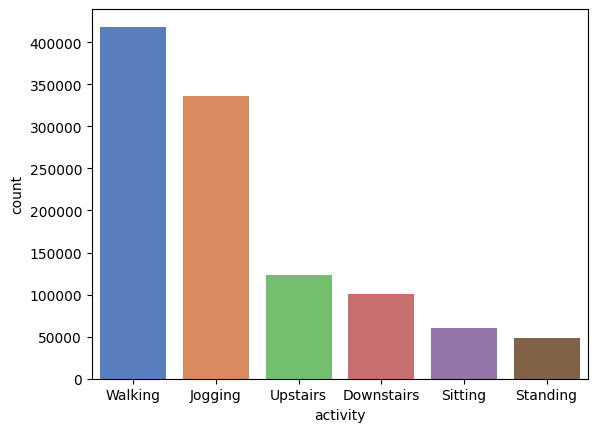

In [4]:
sns.countplot(x='activity', data=df, order = df['activity'].value_counts().index, palette="muted")
plt.show()

## Data Split

In [5]:
df_train = df[df['user_id'] <= 27].copy()
df_test = df[df['user_id'] > 27].copy()

In [6]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1086465, 6)
(801685, 6)
(284780, 6)


## Encoding & Normalization

In [7]:
# Label Encoding
num_cols = ["x", "y", "z"]

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["activity"])
df_test["label"]  = le.transform(df_test["activity"])

# RobustScaler
scaler = RobustScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_test[num_cols]  = scaler.transform(df_test[num_cols])

## Sliding Windows

In [8]:
def create_sliding_windows_with_group(df, window_size=80, step_size=40):
    data, labels, groups = [], [], []
    values = df[["x", "y", "z"]].values
    acts   = df["label"].values
    users  = df["user_id"].values

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = values[start:end]
        label  = np.argmax(np.bincount(acts[start:end]))
        user   = users[start]

        data.append(window)
        labels.append(label)
        groups.append(user)

    return np.array(data), np.array(labels), np.array(groups)

X, y, groups = create_sliding_windows_with_group(df_train)
X_test, y_test, groups_test = create_sliding_windows_with_group(df_test)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)
test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("전체:", X.shape, y.shape, groups.shape)

전체: (20041, 80, 3) (20041,) (20041,)


## GroupKFold

In [9]:
gkf = GroupKFold(n_splits=5)

def get_fold_loaders(fold, batch_size=64):
    train_idx, val_idx = list(gkf.split(X, y, groups))[fold]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val     = X[val_idx], y[val_idx]

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

## Model Creation

In [10]:
class ModelA(nn.Module):
    def __init__(self, num_classes=6):
        super(ModelA, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)

        self.fc = nn.Linear(32 * 80, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 80, 3) -> (batch,, 3, 80)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModelA(num_classes=6).to(device)
print(device)
print(model)

cuda
ModelA(
  (conv1): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2560, out_features=6, bias=True)
)


## Model Training

In [13]:
def train_model(model, train_loader, val_loader, epochs=10):

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, epochs+1):
        # --- Training ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * xb.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
        
        train_acc = correct / total
        train_loss /= total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(yb).sum().item()
                val_total += yb.size(0)
        
        val_acc = val_correct / val_total
        val_loss /= val_total

        # --- 로그 저장 ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)   
        
        print(f"Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")   

    return history


===== Fold 1 =====
Epoch 01 | Train Loss: 0.6128, Acc: 0.7589 | Val Loss: 0.8423, Acc: 0.7434
Epoch 02 | Train Loss: 0.3582, Acc: 0.8744 | Val Loss: 0.8448, Acc: 0.7590
Epoch 03 | Train Loss: 0.2671, Acc: 0.9093 | Val Loss: 0.9440, Acc: 0.7419
Epoch 04 | Train Loss: 0.2170, Acc: 0.9309 | Val Loss: 1.1602, Acc: 0.7129
Epoch 05 | Train Loss: 0.1858, Acc: 0.9388 | Val Loss: 0.9815, Acc: 0.7577
Epoch 06 | Train Loss: 0.1663, Acc: 0.9471 | Val Loss: 1.0250, Acc: 0.7739
Epoch 07 | Train Loss: 0.1502, Acc: 0.9514 | Val Loss: 1.0272, Acc: 0.7695
Epoch 08 | Train Loss: 0.1303, Acc: 0.9583 | Val Loss: 1.0150, Acc: 0.7478
Epoch 09 | Train Loss: 0.1358, Acc: 0.9522 | Val Loss: 1.6267, Acc: 0.6481
Epoch 10 | Train Loss: 0.1307, Acc: 0.9574 | Val Loss: 1.1083, Acc: 0.7787
Epoch 11 | Train Loss: 0.0914, Acc: 0.9727 | Val Loss: 1.7062, Acc: 0.6714
Epoch 12 | Train Loss: 0.0955, Acc: 0.9708 | Val Loss: 1.1560, Acc: 0.7762
Epoch 13 | Train Loss: 0.0769, Acc: 0.9750 | Val Loss: 1.3119, Acc: 0.7383
Epoch

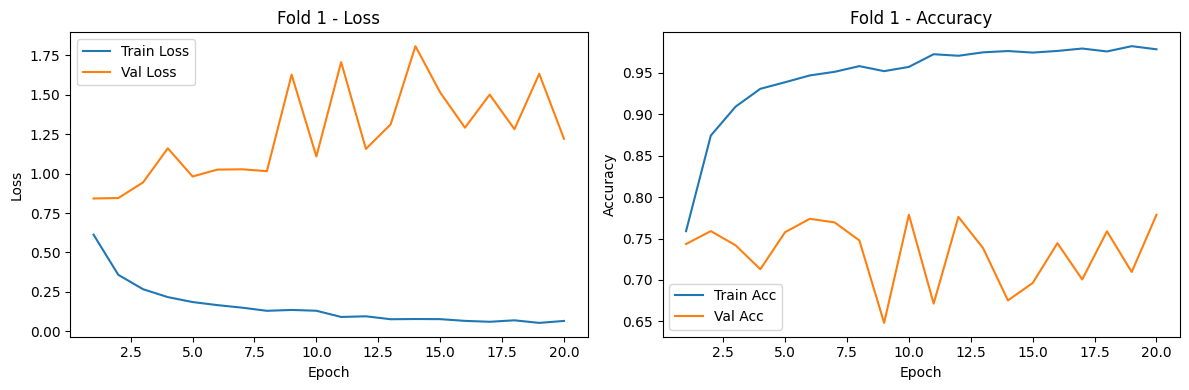

Fold 1 Accuracy: 0.7787

===== Fold 2 =====
Epoch 01 | Train Loss: 0.6507, Acc: 0.7347 | Val Loss: 0.7571, Acc: 0.6793
Epoch 02 | Train Loss: 0.3975, Acc: 0.8642 | Val Loss: 0.6937, Acc: 0.7487
Epoch 03 | Train Loss: 0.2966, Acc: 0.9035 | Val Loss: 0.6513, Acc: 0.7844
Epoch 04 | Train Loss: 0.2425, Acc: 0.9240 | Val Loss: 0.7513, Acc: 0.7430
Epoch 05 | Train Loss: 0.2069, Acc: 0.9365 | Val Loss: 0.5559, Acc: 0.8086
Epoch 06 | Train Loss: 0.1792, Acc: 0.9457 | Val Loss: 0.6777, Acc: 0.8083
Epoch 07 | Train Loss: 0.1471, Acc: 0.9574 | Val Loss: 0.8718, Acc: 0.7387
Epoch 08 | Train Loss: 0.1294, Acc: 0.9636 | Val Loss: 0.6819, Acc: 0.8193
Epoch 09 | Train Loss: 0.1196, Acc: 0.9659 | Val Loss: 0.6733, Acc: 0.8071
Epoch 10 | Train Loss: 0.1008, Acc: 0.9714 | Val Loss: 0.6433, Acc: 0.8100
Epoch 11 | Train Loss: 0.1057, Acc: 0.9682 | Val Loss: 0.8178, Acc: 0.7952
Epoch 12 | Train Loss: 0.0891, Acc: 0.9741 | Val Loss: 0.8176, Acc: 0.7868
Epoch 13 | Train Loss: 0.0864, Acc: 0.9748 | Val Loss: 0

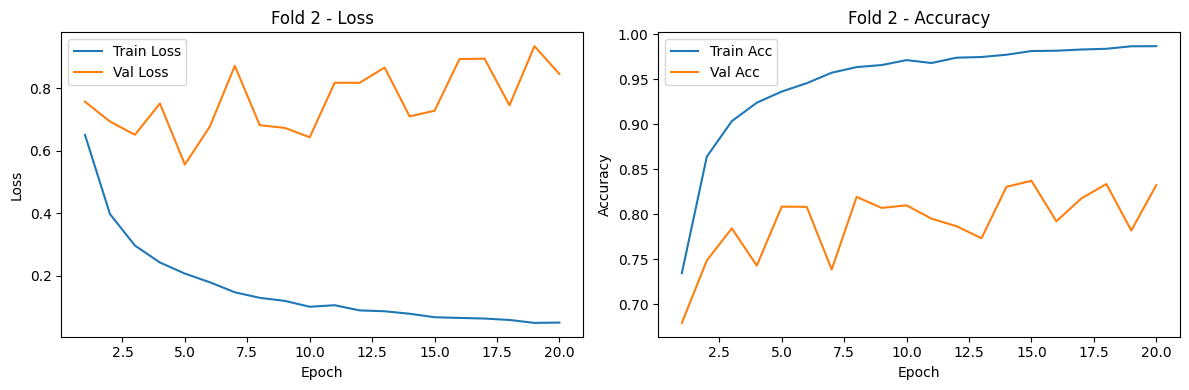

Fold 2 Accuracy: 0.8325

===== Fold 3 =====
Epoch 01 | Train Loss: 0.6085, Acc: 0.7521 | Val Loss: 0.6608, Acc: 0.7186
Epoch 02 | Train Loss: 0.3481, Acc: 0.8752 | Val Loss: 0.6749, Acc: 0.7453
Epoch 03 | Train Loss: 0.2614, Acc: 0.9140 | Val Loss: 0.4943, Acc: 0.8157
Epoch 04 | Train Loss: 0.2192, Acc: 0.9282 | Val Loss: 0.5460, Acc: 0.7883
Epoch 05 | Train Loss: 0.1753, Acc: 0.9463 | Val Loss: 0.5819, Acc: 0.7998
Epoch 06 | Train Loss: 0.1522, Acc: 0.9540 | Val Loss: 0.5638, Acc: 0.8003
Epoch 07 | Train Loss: 0.1500, Acc: 0.9536 | Val Loss: 0.5546, Acc: 0.8146
Epoch 08 | Train Loss: 0.1210, Acc: 0.9641 | Val Loss: 0.6708, Acc: 0.8070
Epoch 09 | Train Loss: 0.1081, Acc: 0.9676 | Val Loss: 0.5791, Acc: 0.8195
Epoch 10 | Train Loss: 0.1115, Acc: 0.9675 | Val Loss: 0.6091, Acc: 0.7957
Epoch 11 | Train Loss: 0.1154, Acc: 0.9641 | Val Loss: 0.6525, Acc: 0.8093
Epoch 12 | Train Loss: 0.0927, Acc: 0.9722 | Val Loss: 0.6524, Acc: 0.8121
Epoch 13 | Train Loss: 0.0782, Acc: 0.9772 | Val Loss: 0

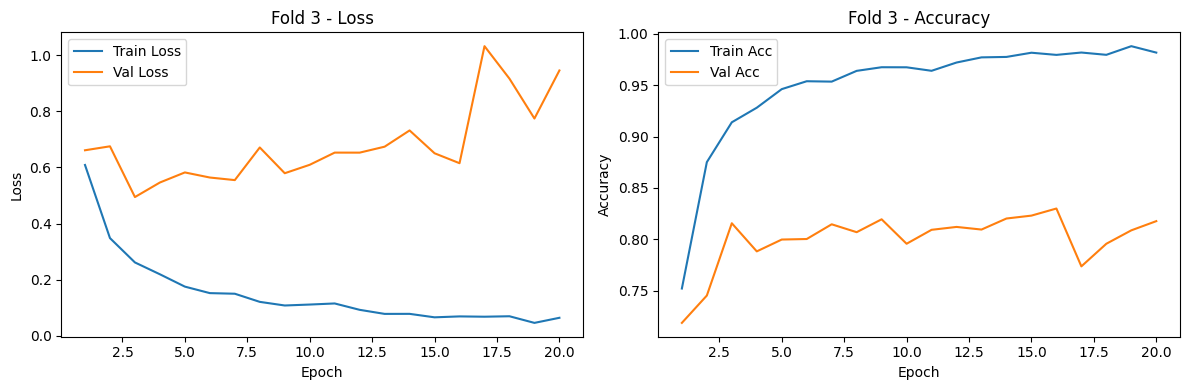

Fold 3 Accuracy: 0.8177

===== Fold 4 =====
Epoch 01 | Train Loss: 0.5650, Acc: 0.7792 | Val Loss: 0.9362, Acc: 0.7642
Epoch 02 | Train Loss: 0.3504, Acc: 0.8738 | Val Loss: 1.0446, Acc: 0.7699
Epoch 03 | Train Loss: 0.2494, Acc: 0.9173 | Val Loss: 0.9803, Acc: 0.7500
Epoch 04 | Train Loss: 0.2106, Acc: 0.9267 | Val Loss: 1.0612, Acc: 0.7423
Epoch 05 | Train Loss: 0.1707, Acc: 0.9473 | Val Loss: 1.3374, Acc: 0.6867
Epoch 06 | Train Loss: 0.1589, Acc: 0.9502 | Val Loss: 1.2790, Acc: 0.7167
Epoch 07 | Train Loss: 0.1446, Acc: 0.9562 | Val Loss: 1.4832, Acc: 0.6663
Epoch 08 | Train Loss: 0.1319, Acc: 0.9577 | Val Loss: 1.1883, Acc: 0.7742
Epoch 09 | Train Loss: 0.1270, Acc: 0.9592 | Val Loss: 1.3155, Acc: 0.7349
Epoch 10 | Train Loss: 0.1056, Acc: 0.9673 | Val Loss: 1.3621, Acc: 0.7363
Epoch 11 | Train Loss: 0.1034, Acc: 0.9672 | Val Loss: 1.4684, Acc: 0.6730
Epoch 12 | Train Loss: 0.1075, Acc: 0.9657 | Val Loss: 1.5795, Acc: 0.7452
Epoch 13 | Train Loss: 0.0963, Acc: 0.9682 | Val Loss: 1

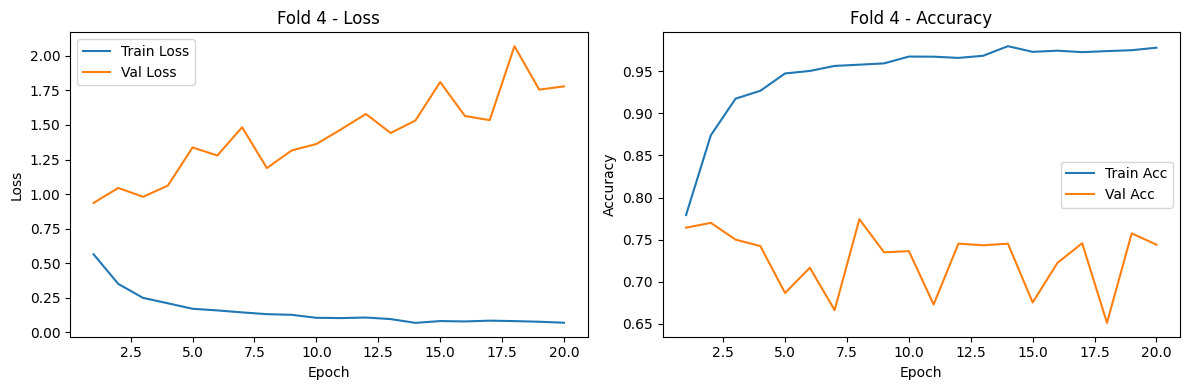

Fold 4 Accuracy: 0.7440

===== Fold 5 =====
Epoch 01 | Train Loss: 0.6507, Acc: 0.7239 | Val Loss: 0.6150, Acc: 0.7283
Epoch 02 | Train Loss: 0.4001, Acc: 0.8513 | Val Loss: 0.3991, Acc: 0.8537
Epoch 03 | Train Loss: 0.3007, Acc: 0.8941 | Val Loss: 0.2807, Acc: 0.9057
Epoch 04 | Train Loss: 0.2424, Acc: 0.9137 | Val Loss: 0.3247, Acc: 0.8759
Epoch 05 | Train Loss: 0.1988, Acc: 0.9319 | Val Loss: 0.2356, Acc: 0.9091
Epoch 06 | Train Loss: 0.1882, Acc: 0.9349 | Val Loss: 0.2658, Acc: 0.9032
Epoch 07 | Train Loss: 0.1631, Acc: 0.9456 | Val Loss: 0.2853, Acc: 0.8998
Epoch 08 | Train Loss: 0.1400, Acc: 0.9546 | Val Loss: 0.3196, Acc: 0.8903
Epoch 09 | Train Loss: 0.1286, Acc: 0.9583 | Val Loss: 0.2458, Acc: 0.9119
Epoch 10 | Train Loss: 0.1171, Acc: 0.9640 | Val Loss: 0.2287, Acc: 0.9186
Epoch 11 | Train Loss: 0.1169, Acc: 0.9624 | Val Loss: 0.3379, Acc: 0.9078
Epoch 12 | Train Loss: 0.1039, Acc: 0.9667 | Val Loss: 0.2603, Acc: 0.9194
Epoch 13 | Train Loss: 0.0927, Acc: 0.9718 | Val Loss: 0

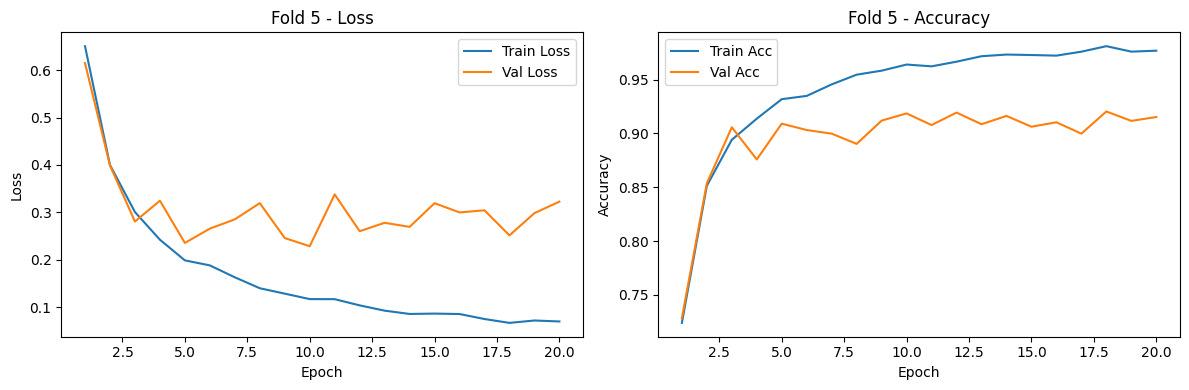

Fold 5 Accuracy: 0.9153

=== K-Fold 평균 정확도 ===
Mean Acc: 0.8176, Std: 0.0578


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_val_acc = 0.0
best_model_state = None
best_class_weights = None


fold_accs = []
for fold in range(5):
    print(f"\n===== Fold {fold+1} =====")
    train_loader, val_loader = get_fold_loaders(fold, batch_size=64)
    
    model = ModelA(num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 클래스 가중치 (train fold 기준)
    y_train_fold = np.array([y for _, y in train_loader.dataset])
    classes, counts = np.unique(y_train_fold, return_counts=True)
    weights = (counts.sum() / (len(classes) * counts)).astype(np.float32)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # 학습 (히스토리 저장)
    history = train_model(model, train_loader, val_loader, epochs=20)

    # fold 최고 성능 기록
    val_acc = max(history["val_acc"])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        best_class_weights = class_weights

    # 시각화
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))

    # Loss 곡선
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(False)

    # Accuracy 곡선
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()
    
    # fold 성능 저장
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(yb).sum().item()
            val_total += yb.size(0)
    acc = val_correct / val_total
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    fold_accs.append(acc)

print("\n=== K-Fold 평균 정확도 ===")
print(f"Mean Acc: {np.mean(fold_accs):.4f}, Std: {np.std(fold_accs):.4f}")

## Check class distribution by Fold

In [15]:
# Fold별 class 분포 확인
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    print(f"\nFold {fold+1} Validation Set Class Distribution:")
    for cls_idx, ratio in counts.items():
        print(f"  Class {cls_idx}: {ratio:.2%}")


Fold 1 Validation Set Class Distribution:
  Class 0: 8.32%
  Class 1: 30.35%
  Class 2: 13.55%
  Class 3: 6.84%
  Class 4: 8.94%
  Class 5: 32.01%

Fold 2 Validation Set Class Distribution:
  Class 0: 6.96%
  Class 1: 30.82%
  Class 2: 4.19%
  Class 3: 3.59%
  Class 4: 9.52%
  Class 5: 44.92%

Fold 3 Validation Set Class Distribution:
  Class 0: 7.94%
  Class 1: 35.69%
  Class 2: 3.81%
  Class 3: 4.97%
  Class 4: 9.83%
  Class 5: 37.76%

Fold 4 Validation Set Class Distribution:
  Class 0: 10.68%
  Class 1: 28.77%
  Class 2: 3.02%
  Class 3: 1.92%
  Class 4: 15.76%
  Class 5: 39.85%

Fold 5 Validation Set Class Distribution:
  Class 0: 10.76%
  Class 1: 35.05%
  Class 2: 1.80%
  Class 3: 2.86%
  Class 4: 12.41%
  Class 5: 37.11%


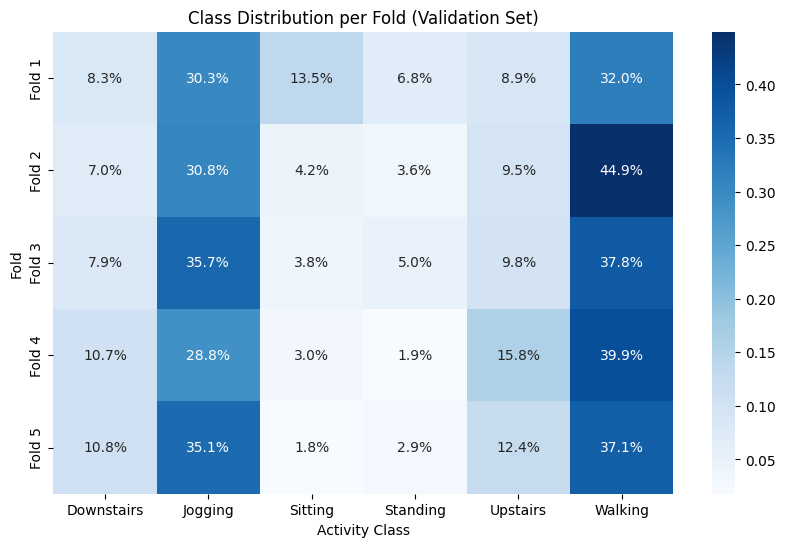

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

dist_per_fold = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    dist_per_fold.append(counts)

dist_df = pd.DataFrame(dist_per_fold).fillna(0)
dist_df.index = [f"Fold {i+1}" for i in range(len(dist_df))]
dist_df.columns = le.classes_  # activity 이름으로 열 바꾸기

plt.figure(figsize=(10,6))
sns.heatmap(dist_df, annot=True, fmt=".1%", cmap="Blues")
plt.title("Class Distribution per Fold (Validation Set)")
plt.ylabel("Fold")
plt.xlabel("Activity Class")
plt.show()

## Model Evaluation

In [17]:
# test
def test_loop(model, test_loader, criterion, device="cpu"):
    model.eval()  # 평가 모드 (Dropout/BatchNorm 비활성화)
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():  # 테스트 시에는 gradient 계산 끔
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            # forward
            outputs = model(xb)
            loss = criterion(outputs, yb)

            # 손실 누적 (평균 내기 위해 샘플 수 곱해줌)
            test_loss += loss.item() * xb.size(0)

            # 예측값
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    
    avg_loss = test_loss / total
    acc = correct / total
    return avg_loss, acc, np.array(all_preds), np.array(all_labels)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ModelA(num_classes=6).to(device)
model.load_state_dict(best_model_state)

criterion = nn.CrossEntropyLoss(weight=best_class_weights)

test_loss, test_acc, all_preds, all_labels = test_loop(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 1.0138, Test Accuracy: 0.8175


In [19]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

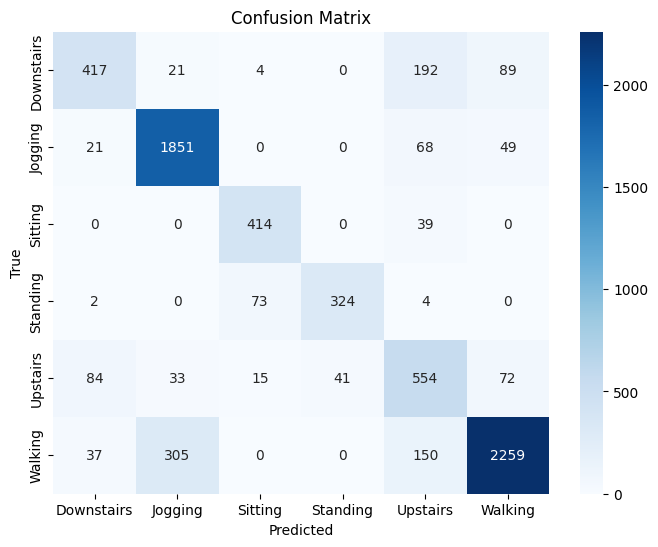

In [20]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

  Downstairs       0.74      0.58      0.65       723
     Jogging       0.84      0.93      0.88      1989
     Sitting       0.82      0.91      0.86       453
    Standing       0.89      0.80      0.84       403
    Upstairs       0.55      0.69      0.61       799
     Walking       0.91      0.82      0.87      2751

    accuracy                           0.82      7118
   macro avg       0.79      0.79      0.79      7118
weighted avg       0.83      0.82      0.82      7118

